In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import os
import glob
import numpy as np 
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from PIL import Image
from time import time
import cv2
import math
from skimage.filters import threshold_otsu
from sklearn.metrics import jaccard_score


In [ ]:
#################################################
#############         SENTINEL 1  @##############
#################################################

y_true = []
x_true = [] 


test_path = '/content/drive/MyDrive/OmbriaS1/test'
maskFolder = "MASK"
path = os.path.join(test_path ,maskFolder)
path1 = os.listdir(path)
path1.sort()
for filename in path1 :
      img = io.imread(os.path.join(path,filename)) 
      img = img / 255
      y_true.append(img)


imgFolder = "AFTER"
path = os.path.join(test_path ,imgFolder)
path2 = os.listdir(path)
path2.sort()

for filename in path2 :
      img = io.imread(os.path.join(path,filename)) 
      img = img / 255
      x_true.append(img)





In [4]:
y_true = []
x_true = [] 


test_path = '/content/drive/MyDrive/OmbriaS2/test'
maskFolder = "MASK"
path = os.path.join(test_path ,maskFolder)
path1 = os.listdir(path)
path1.sort()
for filename in path1 :
      img = io.imread(os.path.join(path,filename)) 
      img = img / 255
      y_true.append(img)


imgFolder = "AFTER"
path = os.path.join(test_path ,imgFolder)
path2 = os.listdir(path)
path2.sort()

for filename in path2:
      img = io.imread(os.path.join(path,filename)) 
      img = img / 255
      band3 = img[:,:,2]
      band11 = img[:,:,0]
      mndwi = np.divide((band3-band11),(band3+band11))
      x_true.append(mndwi)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [5]:
y_pred = []
for i in range(0,len(y_true)):
  A = x_true[i]
  A[np.isnan(A)] = -1
  norm = np.divide(A - A.min(),A.max() - A.min())
  thresh = threshold_otsu(norm)
  pred =  x_true[i] > thresh
  y_pred.append(pred)

70

In [6]:
def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
 
        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    
    mean_IU_= jaccard_score(eval_segm.ravel(), gt_segm.ravel(),average =None)[1]


    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

'''
Exceptions
'''
class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)


def IoU(y_true,y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    union = keras.sum(y_true_f) + keras.sum(y_pred_f) - intersection
    return intersection/union
     
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)
  
def bce_dice_loss(y_true, y_predict):
    return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

def  dice_loss(y_true, y_predict):
    return (1-dice_coef(y_true, y_predict))

"""
_dice.py : Dice coefficient for comparing set similarity.
"""



def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [7]:
pix_acc = []
mean_IoU = []
FW_IoU =[]

for i in range(0,len(y_true)):

  pix_acc.append(pixel_accuracy(y_pred[i], y_true[i]))
  mean_IoU.append(mean_IU(y_pred[i], y_true[i]))
  FW_IoU.append(frequency_weighted_IU(y_pred[i], y_true[i]))

print( pix_acc)
print(mean_IoU) 
print(FW_IoU) 

average_pix_acc = sum(pix_acc) / len(pix_acc)
average_IoU = (sum( mean_IoU)/len( mean_IoU))
average_FW_IoU = (sum( FW_IoU)/len( FW_IoU))

print('Average Pixel Accuracy : ' + str(round(average_pix_acc, 4)) )
print('Mean IoU : ' + str(round(average_IoU , 4)) )   
print('FW IoU : ' + str(round(average_FW_IoU  , 4))  )

[0.9508514404296875, 0.9089508056640625, 0.9218902587890625, 0.26629638671875, 0.9098968505859375, 0.834075927734375, 0.979766845703125, 0.926177978515625, 0.7291259765625, 0.900482177734375, 0.820343017578125, 0.92236328125, 0.85382080078125, 0.783447265625, 0.8686370849609375, 0.4400634765625, 0.641265869140625, 0.48284912109375, 0.864288330078125, 0.889373779296875, 0.820709228515625, 0.953582763671875, 0.908172607421875, 0.8391876220703125, 0.5857696533203125, 0.9036407470703125, 0.8875732421875, 0.92376708984375, 0.949127197265625, 0.94293212890625, 0.953369140625, 0.866485595703125, 0.914764404296875, 0.9246673583984375, 0.7265167236328125, 0.8698272705078125, 0.8533782958984375, 0.9290771484375, 0.5325927734375, 0.6419525146484375, 0.6462860107421875, 0.9470367431640625, 0.5266876220703125, 0.4925994873046875, 0.5663909912109375, 0.7911376953125, 0.7787628173828125, 0.839630126953125, 0.171173095703125, 0.681732177734375, 0.813995361328125, 0.8551025390625, 0.72027587890625, 0.9

In [12]:
indexes = np.argsort(mean_IoU)
print(indexes)

[19 18 16  3 21  4 37 60 13 61 29 17 48 67 15 35  7 24 32 12 23 66  5 25
  2 14 38 68  8 22 59  0  1 55 58 69 10 53 34 33 63 43 36 39 44 42 40 11
 56 28 52 31 30 57 20 49 62 54 26 64  6 45 46  9 50 65 47 41 51 27]


Pixel Accuracy :  0.9238
IoU :  0.8994
FW I:  0.8606


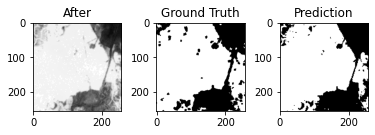

In [14]:
index = 27
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(x_true[index],cmap=plt.cm.gray)
ax.set_title('After')
ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(y_true[index],cmap=plt.cm.gray)
ax.set_title('Ground Truth')
ax = fig.add_subplot(1, 3, 3)

plt.subplots_adjust(wspace=0.4, hspace=0.5)
imgplot = plt.imshow(y_pred[index],cmap=plt.cm.gray)
ax.set_title('Prediction')

print("Pixel Accuracy : ", str(round(pix_acc[index], 4 ))  )

print("IoU : ", str(round(mean_IoU[index], 4 )) )

print("FW I: ", str(round(FW_IoU[index], 4 )) )

In [11]:
save_path = '/content/drive/MyDrive/flood_mapping/NEW/OTSU/'


lista = os.listdir('/content/drive/MyDrive/OmbriaS2/test/MASK')
lista.sort()
for i in range(0,len(lista)):
  im = Image.fromarray((y_pred[i]*255).astype(np.uint8))
  im.save(save_path + "PREDICTIONS/OTSUprediction_"+ lista[i][-8:])